# Surface Form Completion

This notebook is an analysis of the MMLU dataset under the Surface form completion hypothesis, studied by [Wiegreffe et. al (2023)](https://aclanthology.org/2023.emnlp-main.522.pdf).
The major question made by the authors is whether LMs aggregate probabilities over a "neighborhood" from a target string $\ell \in \mathcal{L}$, formalized as a _semantic equivalence class_, $\mathcal{G}_\ell \subset \mathcal{L}$.

The SFC hypothesis states that naïve evaluations of LM outputs only consider the probability $P_\theta(\ell \mid x)$, underestimating model performance.
If, instead, we could add up all semantic equivalent strings, the probability mass would be even greater.
To circunvent this issue, we can measure a **""SFC-free"" prediction** if the equivalent class $\mathcal{G}$ could be easily computed,

$$y^\mathrm{SFC-free} \in \arg\max_{\ell} \sum_{y \in \mathcal{G}_\ell} P_\theta(y \mid x).$$

<center>
<img src="figures/sfc_hypothesis.png" alt="alt_text" />

**Figure 1.** An example of the SFC hypothesis, at the left, although the expected answer is "whirlpool bath", \
other semantic equivalent strings, as "bathtub" and "bath", aggregate probability mass that is not considered \
to the evaluation, leading to an incorrect prediction "puddle" being dominated. If we could constraint (or bias) \
the context to concentrate the probability mass into a single, representative string to the semantic group.
</center>

## Reducing SFC with in-context learning

On way of (synthetically) increasing the model to answer in a specific way, without biasing the accuracy towards the right - or expected - answer, is by changing the context.
If we could change a context $x$ into another $\hat{x}$ such that
$$P_\theta(\mathcal{G}_\ell \mid x) \approx P_\theta(\ell \mid \hat{x}) \quad \forall \ell \in \mathcal{L}$$

_i.e._, ensure that $\mathcal{G}_\ell$ concentrates their probability almost only in $\ell$ instead of their semantic equivalent neighbors, reducing SFC.



In [1]:
from collections.abc import Sequence

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.axes import Axes

free_results = pd.read_feather("results_mmlu_free.feather")
sfc_results = pd.read_feather("results_mmlu_sfc_basic.feather")
sfc_choices_results = pd.read_feather("results_mmlu_sfc_choices.feather")
# sfc_oneshot_results = pd.read_feather("../results_mmlu_sfc_oneshot.feather")
sfc_enum_results = pd.read_feather("results_mmlu_sfc_enum.feather")

results_dfs = {
    "Free": free_results,
    "Question": sfc_results,
    "Question + Choices": sfc_choices_results,
    "Question + A/B/C/D": sfc_enum_results,
    # "Template + Question + Choices": sfc_oneshot_results,
}

for df in results_dfs.values():
    df['causal_effect'] = df['log_likelihood'] - free_results['log_likelihood']

In [2]:
def predicted_choices(df: pd.DataFrame, criterion: str = 'log_likelihood') -> pd.DataFrame:
    return df.loc[
        df.groupby(["model", "arch", "iteration", "index"])[criterion].idxmax().to_numpy()
    ]

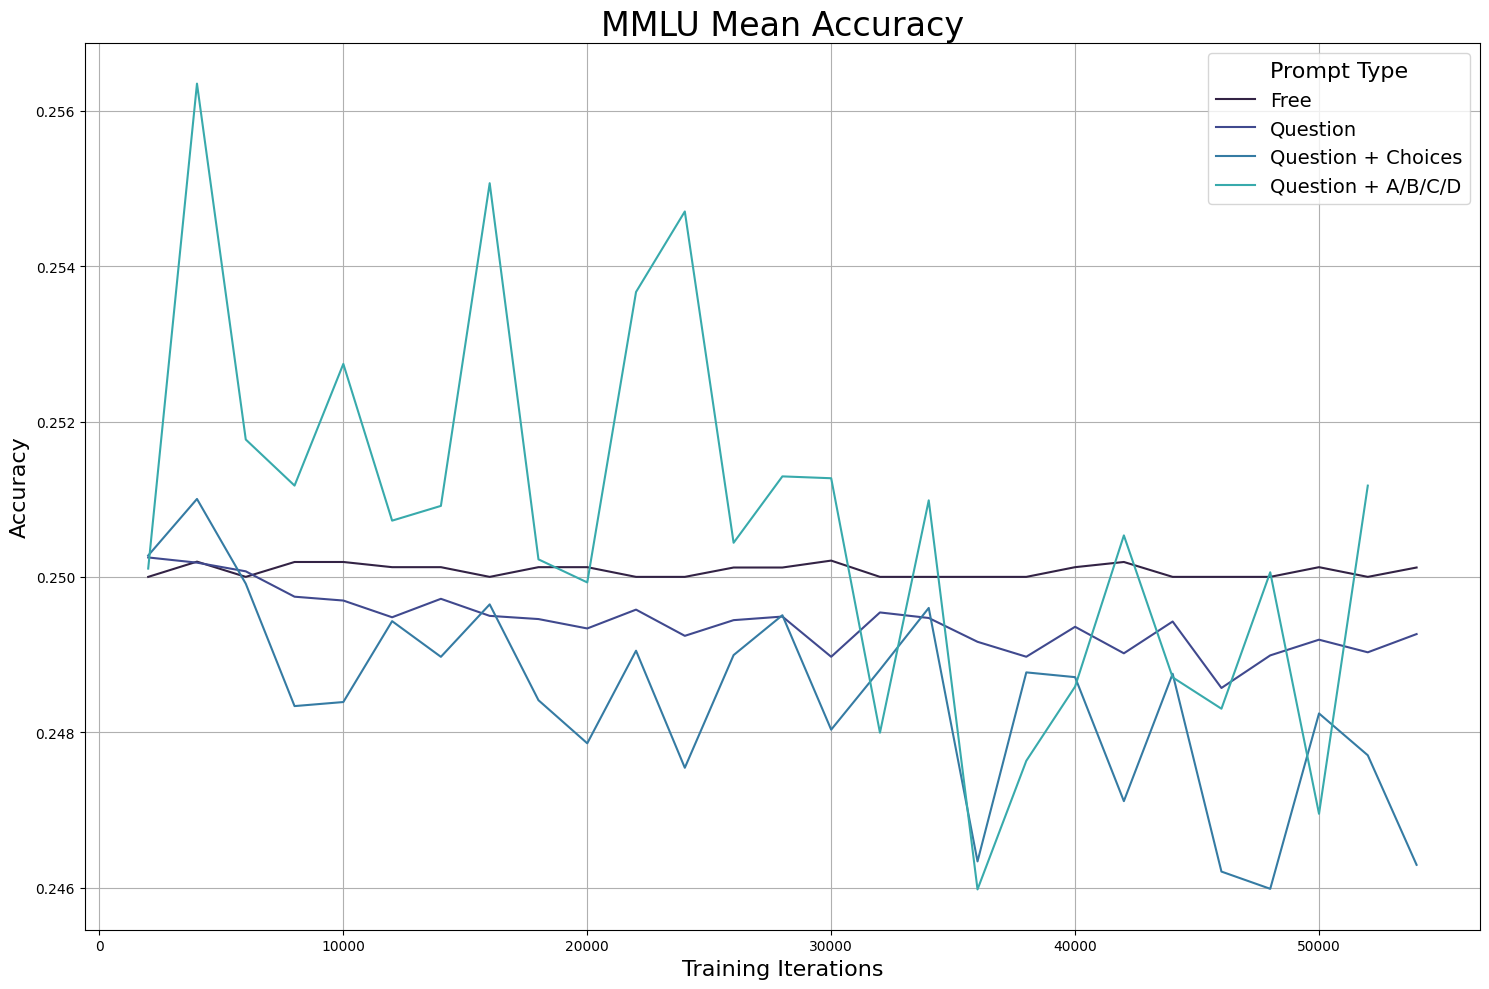

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), sharey=True)
colors = sns.color_palette("mako", 5)

for i, (prompt, df) in enumerate(results_dfs.items()):
    sns.lineplot(
        df.loc[~df['is_greedy'], :].groupby(['model', 'arch', 'iteration'])['correct'].mean().reset_index(),
        x="iteration",
        y="correct",
        color=colors[i],
        label=prompt,  
        ax=ax
    )

ax.set_title('MMLU Mean Accuracy', fontsize=24)

ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Training Iterations', fontsize=16)
ax.grid(True)

ax.legend(title='Prompt Type', title_fontsize=16, fontsize=14)

plt.tight_layout(w_pad=20)
plt.show()

In [9]:
sfc_results.loc[~sfc_results['is_greedy'], 'correct'].mean()

np.float64(0.24941353943075115)

In [6]:
sfc_results[['correct', 'is_greedy']]

,correct,is_greedy
0,False,True
1,True,False
2,False,False
3,False,False
4,False,False
...,...,...
1516531,False,False
1516532,True,False
1516533,False,False
1516534,False,False


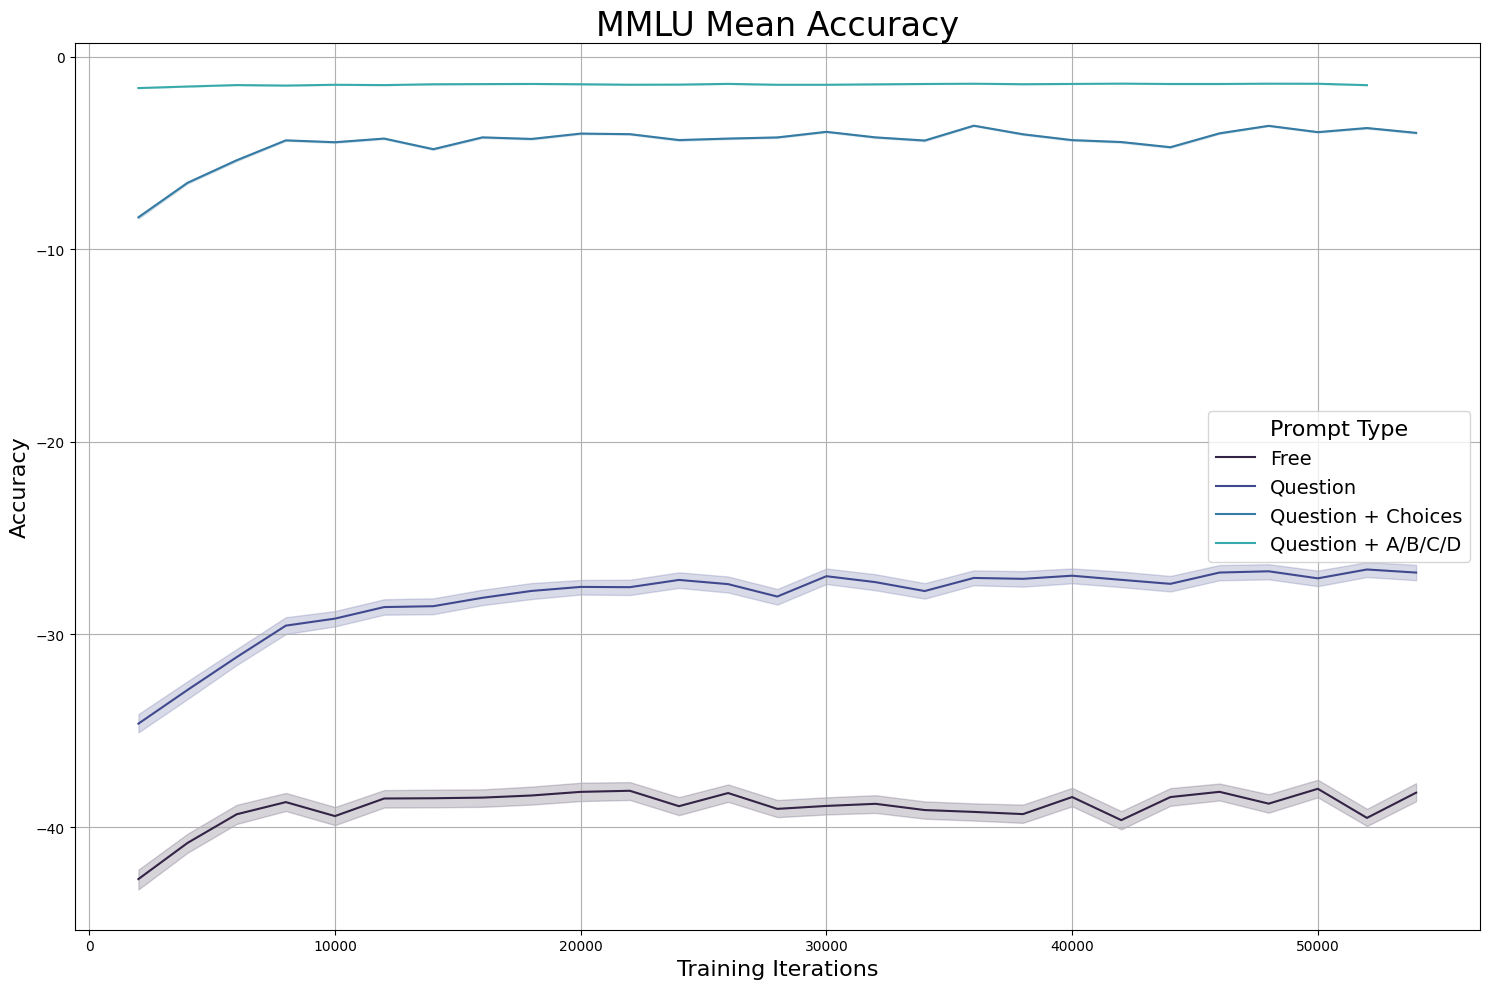

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), sharey=True)
colors = sns.color_palette("mako", 5)

for i, (prompt, df) in enumerate(results_dfs.items()):
    sns.lineplot(
        df.groupby(["model", "arch", "iteration", "index"])["log_likelihood"].mean().reset_index(),
        x="iteration",
        y="log_likelihood",
        color=colors[i],
        label=prompt,  
        ax=ax
    )

ax.set_title('MMLU Mean Accuracy', fontsize=24)

ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Training Iterations', fontsize=16)
ax.grid(True)

ax.legend(title='Prompt Type', title_fontsize=16, fontsize=14)

plt.tight_layout(w_pad=20)
plt.show()

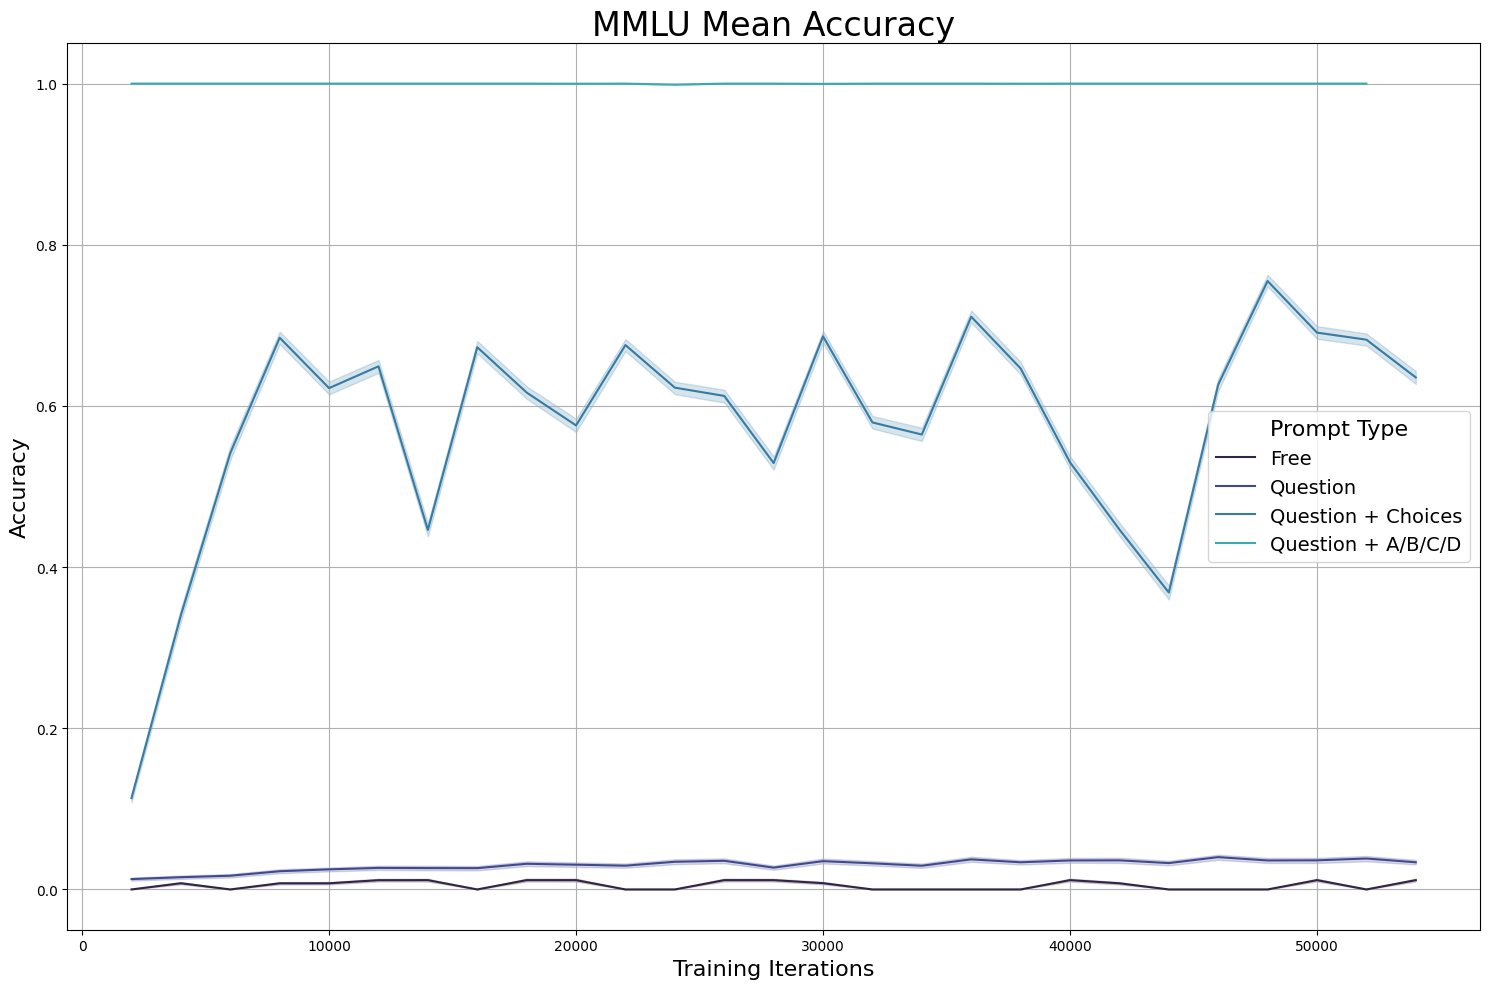

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), sharey=True)
colors = sns.color_palette("mako", 5)

for i, (prompt, df) in enumerate(results_dfs.items()):
    sns.lineplot(
        df.groupby(["model", "arch", "iteration", "index"])["is_greedy"].any().reset_index(),
        x="iteration",
        y="is_greedy",
        color=colors[i],
        label=prompt,  
        ax=ax
    )

ax.set_title('MMLU Mean Accuracy', fontsize=24)

ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Training Iterations', fontsize=16)
ax.grid(True)

ax.legend(title='Prompt Type', title_fontsize=16, fontsize=14)

plt.tight_layout(w_pad=20)
plt.show()

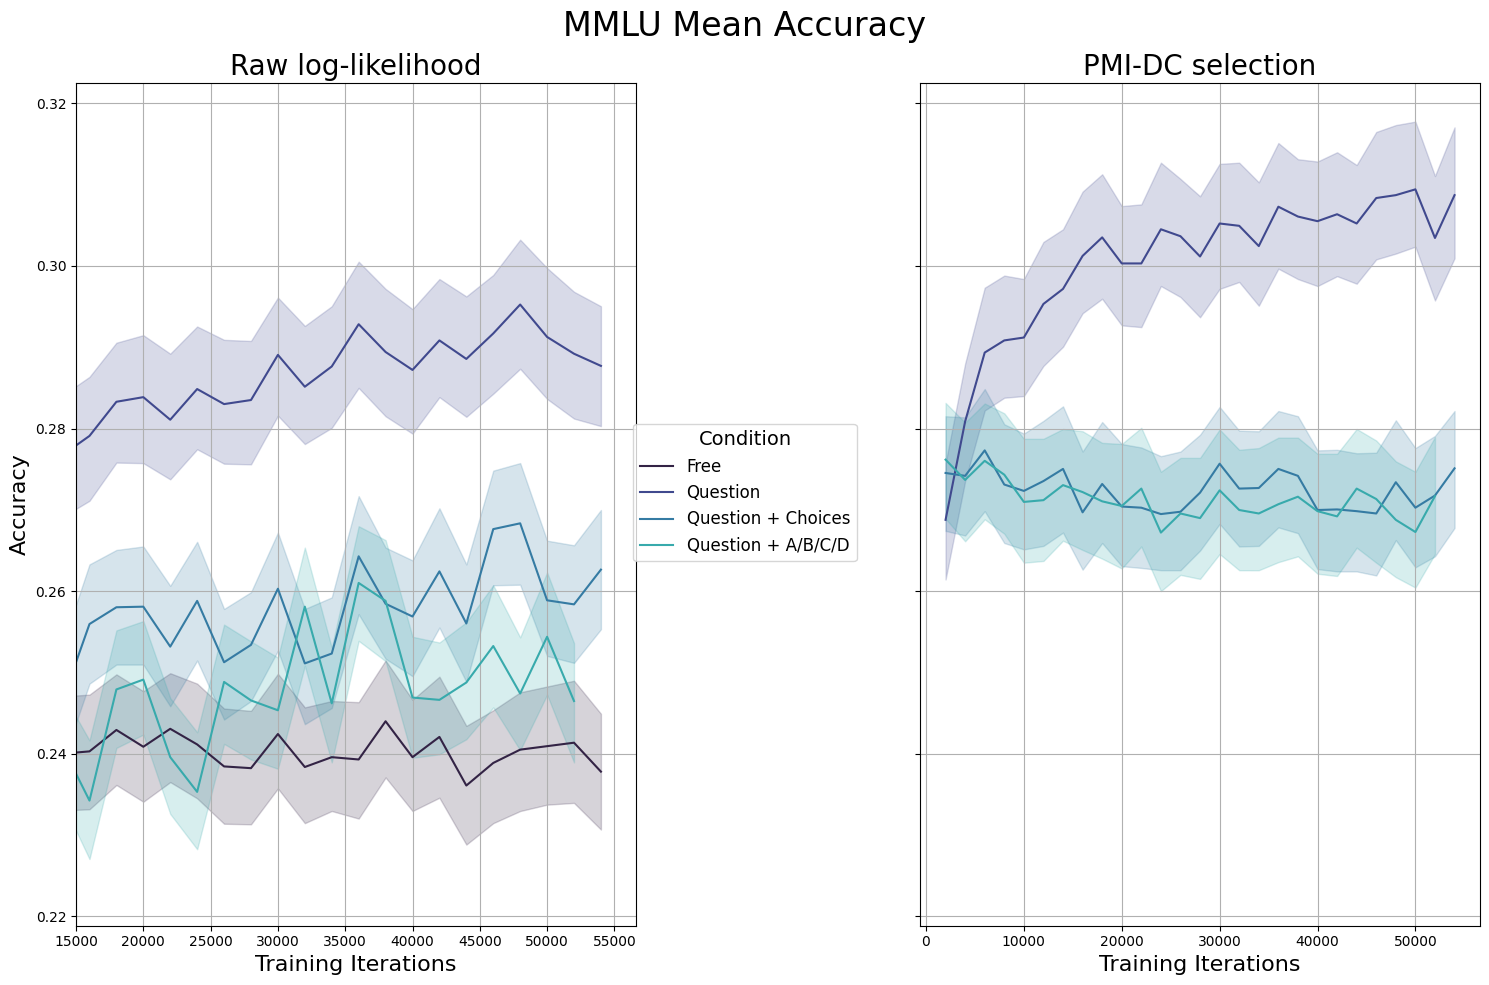

In [ ]:
axs: Sequence[Axes]
fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
colors = sns.color_palette("mako", 5)

for i, (prompt, df) in enumerate(results_dfs.items()):
    sns.lineplot(
        predicted_choices(df),
        x='iteration',
        y='correct',
        color=colors[i],
        label=prompt,
        ax=axs[0],
    )

    if prompt != "Free":
        sns.lineplot(
            predicted_choices(df, criterion='causal_effect'),
            x='iteration',
            y='correct',
            color=colors[i],
            label=prompt,
            ax=axs[1],
        )

fig.suptitle('MMLU Mean Accuracy', fontsize=24)

axs[0].set_title('Raw log-likelihood', fontsize=20)
axs[0].set_ylabel('Accuracy', fontsize=16)
axs[0].set_xlabel('Training Iterations', fontsize=16)
axs[0].grid(True)

axs[1].set_title('PMI-DC selection', fontsize=20)
axs[1].set_xlabel('Training Iterations', fontsize=16)
axs[1].grid(True)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=1, fontsize=12, title='Condition', title_fontsize=14)

axs[0].get_legend().remove()
axs[1].get_legend().remove()

plt.tight_layout(w_pad=20)
plt.show()

In [ ]:
axs: Sequence[Axes]
fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
colors = sns.color_palette("mako", 5)

for i, (prompt, df) in enumerate(results_dfs.items()):
    sns.lineplot(
        predicted_choices(df),
        x='iteration',
        y='correct',
        color=colors[i],
        label=prompt,
        ax=axs[0],
    )

    if prompt != "Free":
        sns.lineplot(
            predicted_choices(df, criterion='causal_effect'),
            x='iteration',
            y='correct',
            color=colors[i],
            label=prompt,
            ax=axs[1],
        )

fig.suptitle('MMLU Mean Accuracy', fontsize=24)

axs[0].set_title('Raw log-likelihood', fontsize=20)
axs[0].set_ylabel('Accuracy', fontsize=16)
axs[0].set_xlabel('Training Iterations', fontsize=16)
axs[0].grid(True)

axs[1].set_title('PMI-DC selection', fontsize=20)
axs[1].set_xlabel('Training Iterations', fontsize=16)
axs[1].grid(True)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=1, fontsize=12, title='Condition', title_fontsize=14)

axs[0].get_legend().remove()
axs[1].get_legend().remove()

plt.tight_layout(w_pad=20)
plt.show()

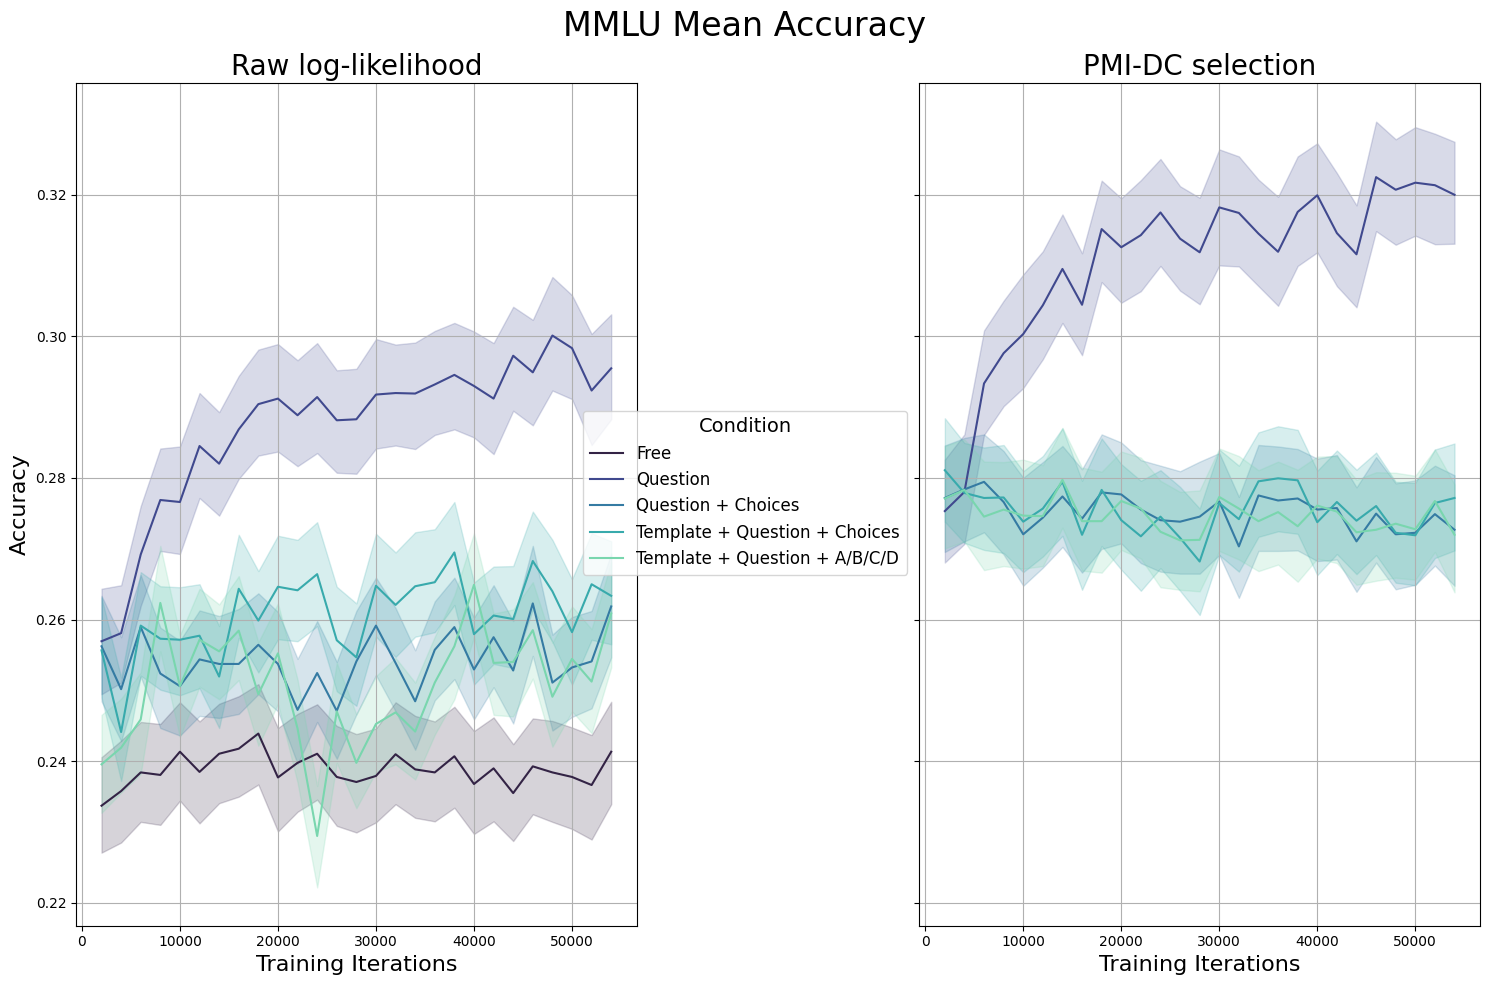

In [5]:
axs: Sequence[Axes]
fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
colors = sns.color_palette("mako", 5)

for i, (prompt, df) in enumerate(results_dfs.items()):
    sns.lineplot(
        predicted_choices(df),
        x='iteration',
        y='correct',
        color=colors[i],
        label=prompt,
        ax=axs[0],
    )

    if prompt != "Free":
        sns.lineplot(
            predicted_choices(df, criterion='causal_effect'),
            x='iteration',
            y='correct',
            color=colors[i],
            label=prompt,
            ax=axs[1],
        )

fig.suptitle('MMLU Mean Accuracy', fontsize=24)

axs[0].set_title('Raw log-likelihood', fontsize=20)
axs[0].set_ylabel('Accuracy', fontsize=16)
axs[0].set_xlabel('Training Iterations', fontsize=16)
axs[0].grid(True)

axs[1].set_title('PMI-DC selection', fontsize=20)
axs[1].set_xlabel('Training Iterations', fontsize=16)
axs[1].grid(True)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=1, fontsize=12, title='Condition', title_fontsize=14)

axs[0].get_legend().remove()
axs[1].get_legend().remove()

plt.tight_layout(w_pad=20)
plt.show()